<a href="https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/julia_shift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import math
from numba import vectorize, cuda
from matplotlib import pyplot as plt
plt.style.use('default')
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

In [0]:
import os
os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so"

In [0]:
@cuda.jit(device=True)
def julia(x, y, max_iters, cin):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Julia
    set given a fixed number of iterations.
    """
    i = 0
    #c = complex(-0.8, 0.156)
    #c = complex(0.274, -0.008)
    #c = complex(0.28, 0.008)
    #c = complex(0.3, -0.01)
    c = complex(cin[0], cin[1])
    a = complex(x,y)
    for i in range(max_iters):
        a = a*a + c
        if (a.real*a.real + a.imag*a.imag) > 1000:
            return int((i/max_iters)*255)
    return 255

In [0]:
@cuda.jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters, c):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    
    x, y = cuda.grid(2)
    
    if x < width and y < height:
      real = min_x + x * pixel_size_x
      imag = min_y + y * pixel_size_y
      color = julia(real, imag, iters, c)
      image[y, x] = color

In [0]:
image = np.zeros((1800, 1800), dtype=np.uint8)
threadsperblock = 16
threads_per_block = (16, 16)
xblocks = (image.shape[1] + (threadsperblock - 1)) // threadsperblock
yblocks = (image.shape[0] + (threadsperblock - 1)) // threadsperblock
blocks_per_grid = (xblocks, yblocks)

In [97]:
reals = np.linspace(0.3,0.28,100)
imags = np.linspace(-0.01,0.008,100)
c = np.column_stack((reals, imags))

array([ 0.3 , -0.01])

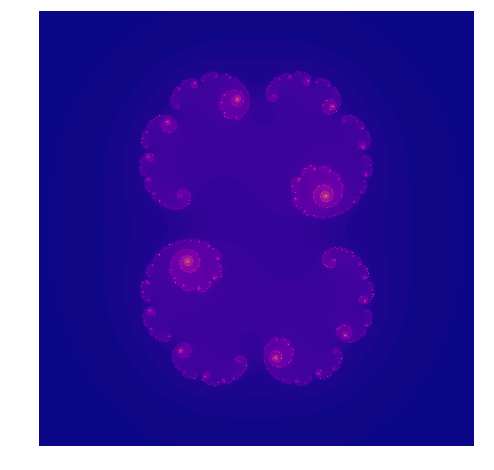

In [126]:
i = 0
create_fractal[blocks_per_grid, threads_per_block](-1.5, 1.5, -1.5, 1.5, image, 200, c[i])
plt.figure(figsize=(8,8))
plt.imshow(image, cmap="plasma")
plt.axis('off')
plt.show()

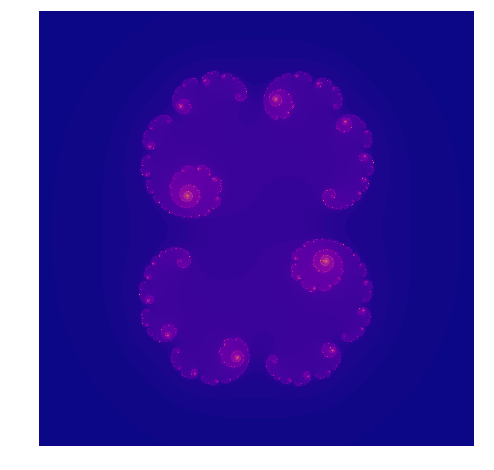

In [127]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(8,8))
plt.xlim(( 0, 1800))
plt.ylim((0, 1800))
plt.axis('off')
im = plt.imshow(image, cmap='plasma', animated=True)

In [0]:
def update_fig(i):
  im.set_array(create_fractal[blocks_per_grid, threads_per_block](-1.5, 1.5, -1.5, 1.5, image, 200, c[i]))
  return im,

In [0]:
# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

In [137]:
# call the animator. blit=True means only re-draw the parts that have changed.
#anim = animation.FuncAnimation(fig, animate, init_func=init, frames=100, interval=20, blit=True)
anim = animation.FuncAnimation(fig, update_fig, frames=100, interval=20, blit=True)
anim

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/animation.py", line 999, in _start
    self._init_draw()
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/animation.py", line 1740, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/animation.py", line 1762, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-136-ed53031d822a>", line 2, in update_fig
    im.set_array(create_fractal[blocks_per_grid, threads_per_block](-1.5, 1.5, -1.5, 1.5, image, 200, c[i]))
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/image.py", line 672, in set_array
    self.set_data(A)
  File "/usr/local/lib/python3.6/dist-packages/matplotlib/image.py", line 634, in set_data
    raise TypeError("Image data cannot b

TypeError: ignored